In [78]:
import csv, json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

with open('settings/config.json', 'r') as jfile:
    CONFIG = json.load(jfile) 

<h3>Load data from file</h3>

In [2]:
FILE_PATH = 'data/ThingsPlaylist{}.csv'

# CSV Args
args = {
    'sep': '|',
    'quoting': csv.QUOTE_NONNUMERIC, 
    'quotechar': '`'
}

# Load data
trackDF = pd.read_csv(FILE_PATH.format(''), **args)
artistDF = pd.read_csv(FILE_PATH.format('_Artists'), **args)
genreDF = pd.read_csv(FILE_PATH.format('_Genres'), **args)

<h2>General Data Analysis</h2>

<h3>General Artist Investigation</h3>

In [26]:
def plotArtistHist(ax, y, nBins=5.0, ov=0.5, vov=10):
    # Generate the dataset
    intervalSize = np.floor(np.max(y) / nBins)
    binCounts,binLabels = [],[]
    a,binCounts,binLabels = 0,[],[]
    
    # Generate the bins and labels
    x,xTickPos = [],[]
    for i in range(int(nBins)):
        b = a + int(intervalSize)
        
        # Generate the label
        if i < (int(nBins) - 1):
            lbl = '{} - {}'.format(a, b-1)
        else:
            lbl = '{}+'.format(a)
        
        # Append values to bin
        x.append(i)
        xTickPos.append(i+ov)
        binCounts.append(0)
        binLabels.append(lbl)
        
        # Increment lower bound
        a = b
    
    # Generate the x and y
    for i in y:
        binNo = int(i // intervalSize)
        if binNo >= nBins:
            binNo = int(nBins) - 1
        binCounts[binNo] = binCounts[binNo] + 1
    
    # Plot it
    ax.bar(x, binCounts, color=CONFIG['colors'][0])
    
    # Format it
    ax.set_xticks(xTickPos)
    ax.set_xticklabels(binLabels, size=12)
    ax.set_yticks([])
    
    for xi,yi in zip(x, binCounts):
        ax.text(xi+ov, yi+vov, yi, ha='center', size=12)
    
    return ax

In [27]:
def plotTopArtists(ax, x, y, yLabels=None, n=10, ov=0.0):
    # Plot it
    ax.barh(y, x, color=CONFIG['colors'][2])
    
    # Format the chart
    ax.set_title('Top {} Artists by Number of Tracks'.format(n), size=14)
    ax.set_xticklabels([])
    ax.set_ylim([0, n])
    ax.set_yticks([i+ov for i in y])
    ax.set_yticklabels(yLabels, size=12)
    
    # Annotate the chart
    for xi,yi in zip(x, y):
        ax.text(xi+ov, yi+ov, xi, ha='left', va='center', size=12)
        
    # Return the completed chart
    return ax

In [28]:
def artistOverviewPlots(data, artistN, nBins, offsetVal=0.4):
    
    # Generate the dataset
    artistCountDF = data.groupby(by=['artistName']).count()['trackID']
    artistCountDF = artistCountDF.sort_values(ascending=False)
    nArtistCountDF = artistCountDF.head(n=artistN)
    
    # Create the plot
    fig,ax = plt.subplots(1, 2, figsize=(20, 10))
    
    # Plot the histogram
    plotArtistHist(ax[0], list(artistCountDF), ov=0.4, vov=10)
    
    # Plot the top artists
    x2 = list(artistCountDF.head(n=artistN))
    y2 = [x for x in range(artistN)]
    y2Labels = list(nArtistCountDF.index)
    y2.reverse()

    # Plot the top N artists
    plotTopArtists(ax[1], x2, y2, yLabels=y2Labels, n=artistN, ov=offsetVal)
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    return (x2, y2, y2Labels)
    

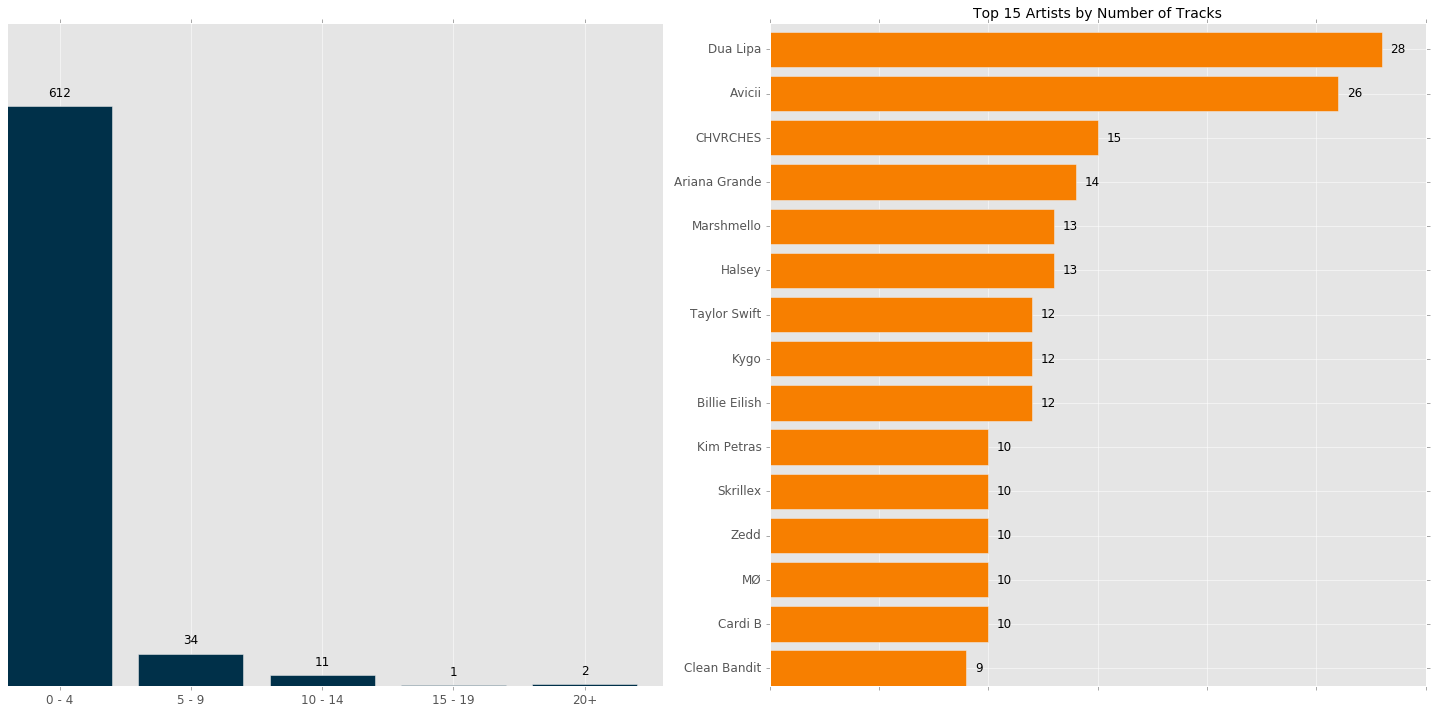

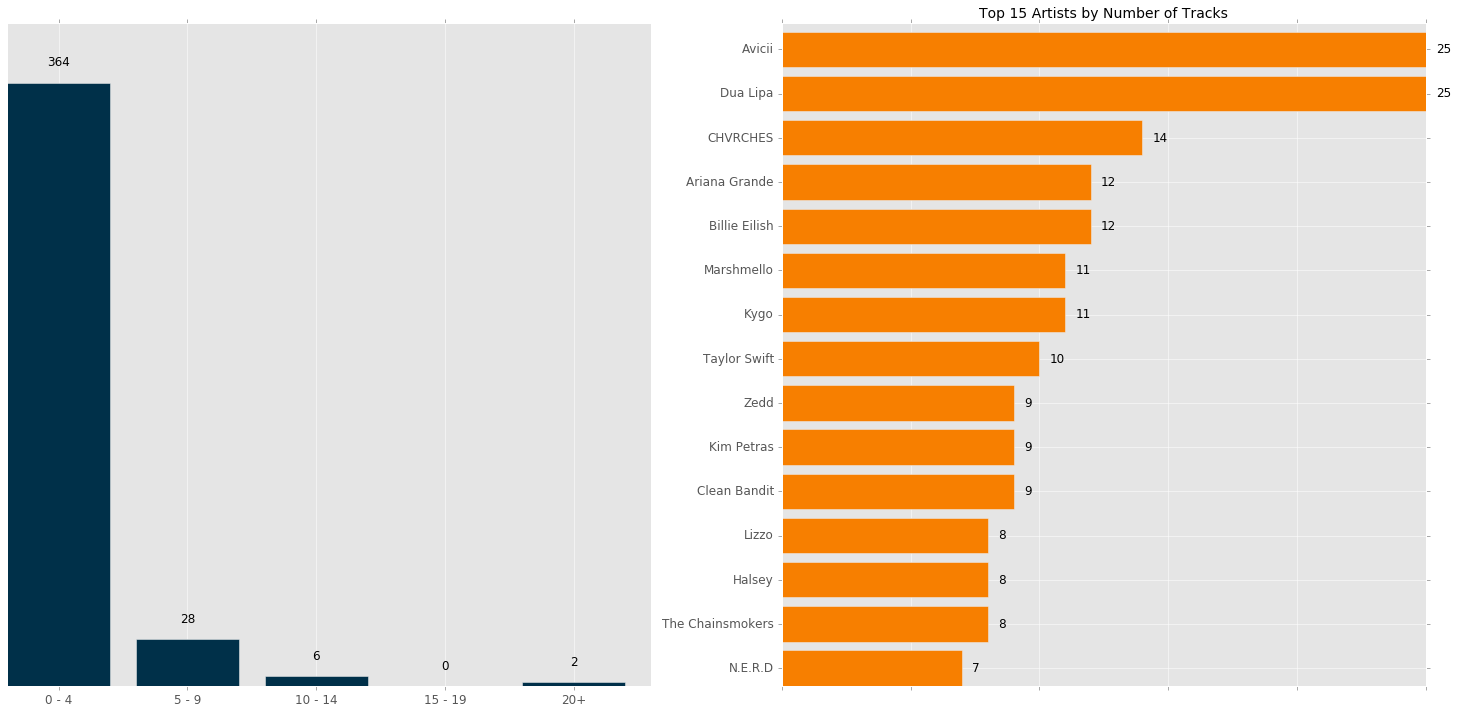

In [29]:
# First things first. What does my artist profile look like?
p1d = artistOverviewPlots(artistDF, 15, 10)

# How about where the artists is the top billed artist on the track
reducedArtistDF = artistDF[artistDF['artistNo'] == 0.0]
p2d = artistOverviewPlots(reducedArtistDF, 15, 10)

In [135]:
def generateColorsForChangePlot(A, rankA, B, rankB, Ca=None, Cb=None,recurse=True):
    if Ca is None: Ca = [None for a in A]
    if Cb is None: Cb = [None for b in B]
    
    colorCounter = 1
    for ai,a in enumerate(A):
        if not (Ca[ai] is None): continue
        # Three conditions
        # 1. A has the same rank (ar) as in B (br)
        # 2. A does not have the same rank as in B
        # 3. A does not exist in B
        
        if a in B:
            ar = rankA[ai]
            
            # Get the index in B
            bi = B.index(a)
            br = rankB[bi]
            
            
            if ar == br:
                # Assign base color
                Ca[ai] = CONFIG['colors'][0]
                Cb[bi] = CONFIG['colors'][0]
            else:
                Ca[ai] = CONFIG['colors'][colorCounter]
                Cb[bi] = CONFIG['colors'][colorCounter]
                colorCounter = colorCounter + 1
        else:
            Ca[ai] = '#000000' if recurse else '#bbbbbb' #CONFIG['colors'][colorCounter]
  
            
    
    if recurse:
        Cb,Ca = generateColorsForChangePlot(B, rankB, A, rankA, Ca=Cb, Cb=Ca, recurse=False)
    
    return Ca,Cb

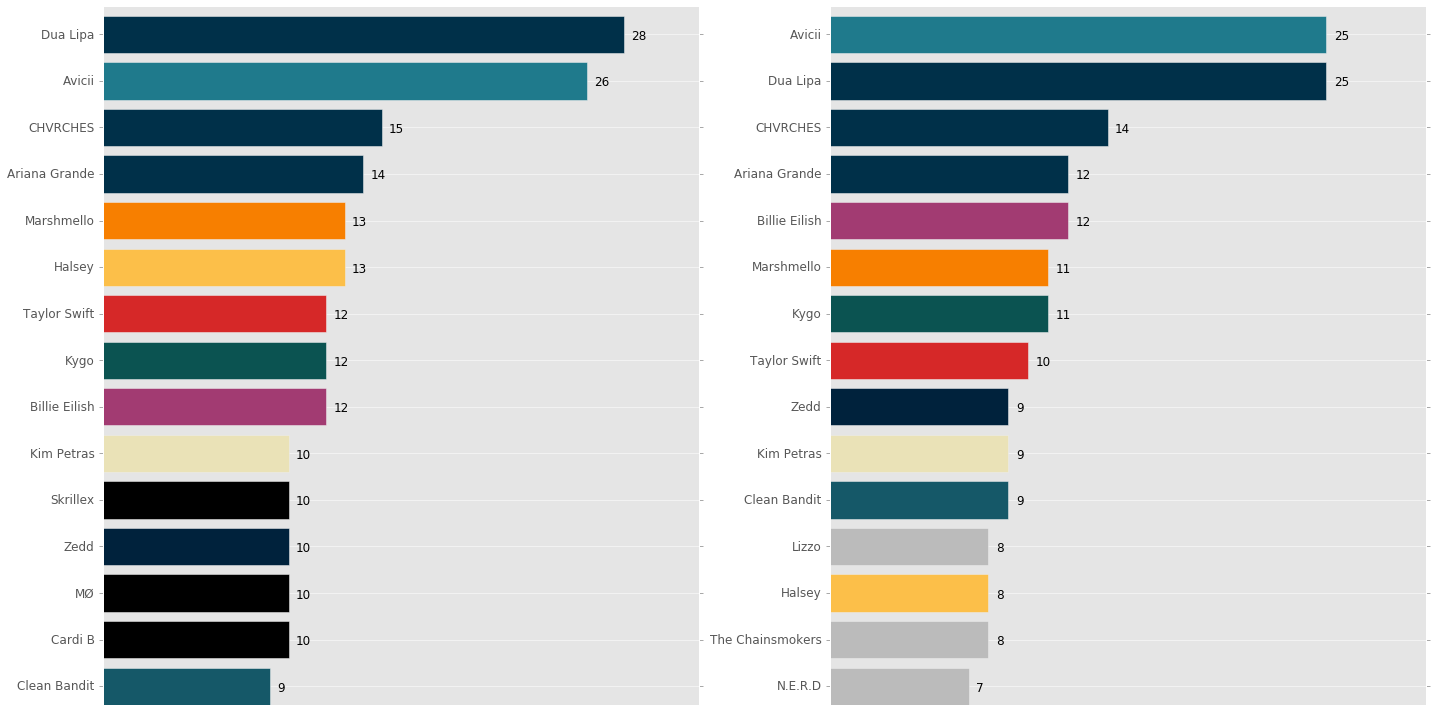

In [145]:
# nonStd,nonStdColor = [], []

# colorCounter = 1
# for i in p1d[2]:
#     if not (i in p2d[2]):
#         nonStd.append(i)
#         nonStdColor.append(CONFIG['colors'][colorCounter])
#         colorCounter = colorCounter + 1
# for i in p2d[2]:
#     if not (i in p1d[2]): 
#         nonStd.append(i)
#         nonStdColor.append(CONFIG['colors'][colorCounter])
#         colorCounter = colorCounter + 1
offsetVal,ov = 0.4, 0.375

maxCount = np.max([np.max(p1d[0]), np.max(p2d[0])])
# Generate the ranks
p1r = generateRank(p1d[0])
p2r = generateRank(p2d[0])

ca,cb = generateColorsForChangePlot(p1d[2], p1r, p2d[2], p2r)

fig,ax = plt.subplots(1,2,figsize=(20,10))

bars1 = ax[0].barh(p1d[1], p1d[0], color=ca)
bars2 = ax[1].barh(p2d[1], p2d[0], color=cb)

ax[0].set_xlim([0, maxCount + 4])
ax[0].set_xticks([])
ax[0].set_yticks([i+offsetVal for i in p1d[1]])
ax[0].set_yticklabels(p1d[2], size=12)
ax[0].set_ylim([0,len(p1d[2])])

ax[1].set_xlim([0, maxCount + 2])
ax[1].set_xticks([])
ax[1].set_yticks([i+offsetVal for i in p2d[1]])
ax[1].set_yticklabels(p2d[2], size=12)
ax[1].set_ylim([0,len(p2d[2])])


for xi,yi in zip(p1d[0], p1d[1]):
    ax[0].text(xi+ov, yi+ov, xi, ha='left', va='center', size=12)
    
for xi,yi in zip(p2d[0], p2d[1]):
    ax[1].text(xi+ov, yi+ov, xi, ha='left', va='center', size=12)
    


plt.tight_layout()
plt.show()

In [87]:
# Generate rank
def generateRank(counts):
    
    previousVal = counts[0]
    ranks = [1]
    
    currentRank = 1
    rankCounter = 2
    for i,currentVal in enumerate(counts[1:]):
        currentRank = rankCounter if currentVal != previousVal else currentRank
        ranks.append(currentRank)
        
        # Increment the previous value
        previousVal = currentVal
        rankCounter = rankCounter + 1
        
    return ranks

In [96]:
print(ca, cb)

['#1F7A8C', '#003049', '#003049', '#003049', '#A23B72', '#F77F00', '#0B5351', '#D62828', '#155868', '#EAE2B7', '#AA1B1B', '#1F7A8C', '#FCBF49', '#F77F00', '#FCBF49'] ['#003049', '#1F7A8C', '#003049', '#003049', '#F77F00', '#FCBF49', '#D62828', '#0B5351', '#A23B72', '#EAE2B7', '#00223C', '#155868', '#BE5600', '#BB8232', '#AA1B1B']


In [77]:
CONFIG['colors']

['#003049',
 '#1F7A8C',
 '#F77F00',
 '#FCBF49',
 '#D62828',
 '#0B5351',
 '#A23B72',
 '#EAE2B7']

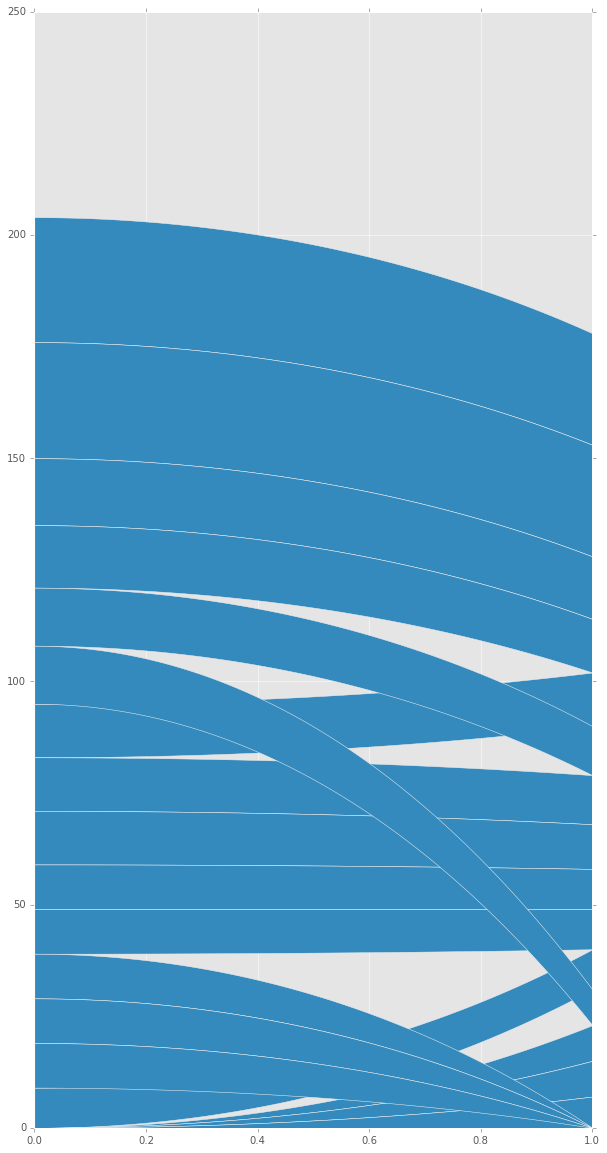

,artist,ct.1,ct.2,y.1.start,y.1.end,y.2.start,y.2.end
0,Dua Lipa,28.0,25.0,204.0,176.0,178.0,153.0
1,Avicii,26.0,25.0,176.0,150.0,153.0,128.0
2,CHVRCHES,15.0,14.0,150.0,135.0,128.0,114.0
3,Ariana Grande,14.0,12.0,135.0,121.0,114.0,102.0
8,Billie Eilish,12.0,12.0,95.0,83.0,102.0,90.0
4,Marshmello,13.0,11.0,121.0,108.0,90.0,79.0
7,Kygo,12.0,11.0,83.0,71.0,79.0,68.0
6,Taylor Swift,12.0,10.0,71.0,59.0,68.0,58.0
9,Kim Petras,10.0,9.0,59.0,49.0,58.0,49.0
11,Zedd,10.0,9.0,49.0,39.0,49.0,40.0


In [10]:
topDF1 = pd.DataFrame({'artist': p1d[2], 'ct': p1d[0]})
topDF2 = pd.DataFrame({'artist': p2d[2], 'ct': p2d[0]})


# topDF1 = pd.DataFrame({'artist': p1d[2], 'ct': [1 for i in p1d[0]]})
# topDF2 = pd.DataFrame({'artist': p2d[2], 'ct': [1 for i in p2d[0]]})
plotSankey(topDF1, topDF2, 'artist', 'ct')

In [11]:
topDF2['ct'].sum()

178

In [16]:
colors = [
    '#003049',
    '#1F7A8C',
    '#F77F00',
    '#FCBF49',
    '#D62828',
    '#0B5351',
    '#A23B72',
    '#EAE2B7'
]

with open('settings/ColorPalette.p', 'w') as pfile:
    p.dump(colors, pfile)

TypeError: write() argument must be str, not bytes

In [22]:
CONFIG

{'colors': ['#003049',
  '#1F7A8C',
  '#F77F00',
  '#FCBF49',
  '#D62828',
  '#0B5351',
  '#A23B72',
  '#EAE2B7']}